#  Egyptian Healthcare Medication Distribution Analysis
## Analyzing Regional Equity and Operational Efficiency

### Project Overview

**Business Problem:**
The Egyptian Ministry of Health distributes medications across 27 governorates
serving 100M+ population. This analysis investigates:
- Are medications distributed equitably across regions?
- What seasonal patterns exist in medication demand?
- How efficient is the distribution system?
- Where should resources be prioritized?

**Dataset:**
- 50,000 medication distribution records (2020-2024)
- 27 Egyptian governorates
- 10 medication categories
- Distribution status, costs, and timing

**Analysis Goals:**
1. Identify underserved regions
2. Discover seasonal demand patterns
3. Evaluate delivery efficiency
4. Recommend resource optimization strategies

**Tools Used:**
Python (Pandas, NumPy, Matplotlib, Plotly), Statistical Analysis

In [57]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

Plotly_template = 'plotly_white'
Colours = {
    'primary': '#2E86AB',
    'secondary': '#A23B72',
    'accent': '#F18F01',
    'success': '#06A77D',
    'warning': '#F77F00',
    'danger': '#D62828'
}

In [58]:
df=pd.read_csv('egyptian_medication_distribution.csv')
df.head(5)

,distribution_id,date,year,month,quarter,governorate,population_millions,region,medication_category,medication_name,quantity_units,cost_per_unit_egp,total_cost_egp,facility_type,distribution_status,priority_level,supplier,per_capita_units,delivery_delay_days
0,DIST-038732,2020-01-01,2020,1,1,Sohag,5.0,Upper Egypt,Cardiovascular,Atenolol,1255,50.56,63455.56,Teaching Hospital,Delivered,High,Supplier_C,0.000251,0
1,DIST-021030,2020-01-01,2020,1,1,New Valley,0.2,Other,Gastrointestinal,Omeprazole,43,14.80,636.43,Rural Clinic,Delivered,Medium,Supplier_D,0.000215,0
2,DIST-009994,2020-01-01,2020,1,1,Sohag,5.0,Upper Egypt,Respiratory,Prednisolone,2332,35.15,81958.67,Specialized Center,Partial,High,Supplier_C,0.000466,6
3,DIST-010430,2020-01-01,2020,1,1,New Valley,0.2,Other,Diabetes,Sitagliptin,109,193.58,21100.45,Specialized Center,Delivered,Medium,Supplier_D,0.000545,0
4,DIST-023506,2020-01-01,2020,1,1,Qaliubiya,5.6,Other,Neurological,Gabapentin,908,63.50,57659.93,Rural Clinic,Delivered,Medium,Supplier_B,0.000162,0


# Data Information

In [59]:
def info(x):
    print('Number of rows:',x.shape[0])
    print('Number of columns:',x.shape[1])
    print('Data Types:',x.dtypes)
    print('Number of unique values:',x.nunique())
    print('Sum of null values:',x.isnull().sum())

info(df)


Number of rows: 50000
Number of columns: 19
Data Types: distribution_id         object
date                    object
year                     int64
month                    int64
quarter                  int64
governorate             object
population_millions    float64
region                  object
medication_category     object
medication_name         object
quantity_units           int64
cost_per_unit_egp      float64
total_cost_egp         float64
facility_type           object
distribution_status     object
priority_level          object
supplier                object
per_capita_units       float64
delivery_delay_days      int64
dtype: object
Number of unique values: distribution_id        50000
date                    1827
year                       5
month                     12
quarter                    4
governorate               27
population_millions       21
region                     3
medication_category       10
medication_name           40
quantity_units          65

In [60]:
duplicated_values=df.duplicated(keep=False).to_frame().value_counts()
duplicated_values

0    
False    50000
Name: count, dtype: int64

Correlation Analysis

Examining relationships between numerical variables...



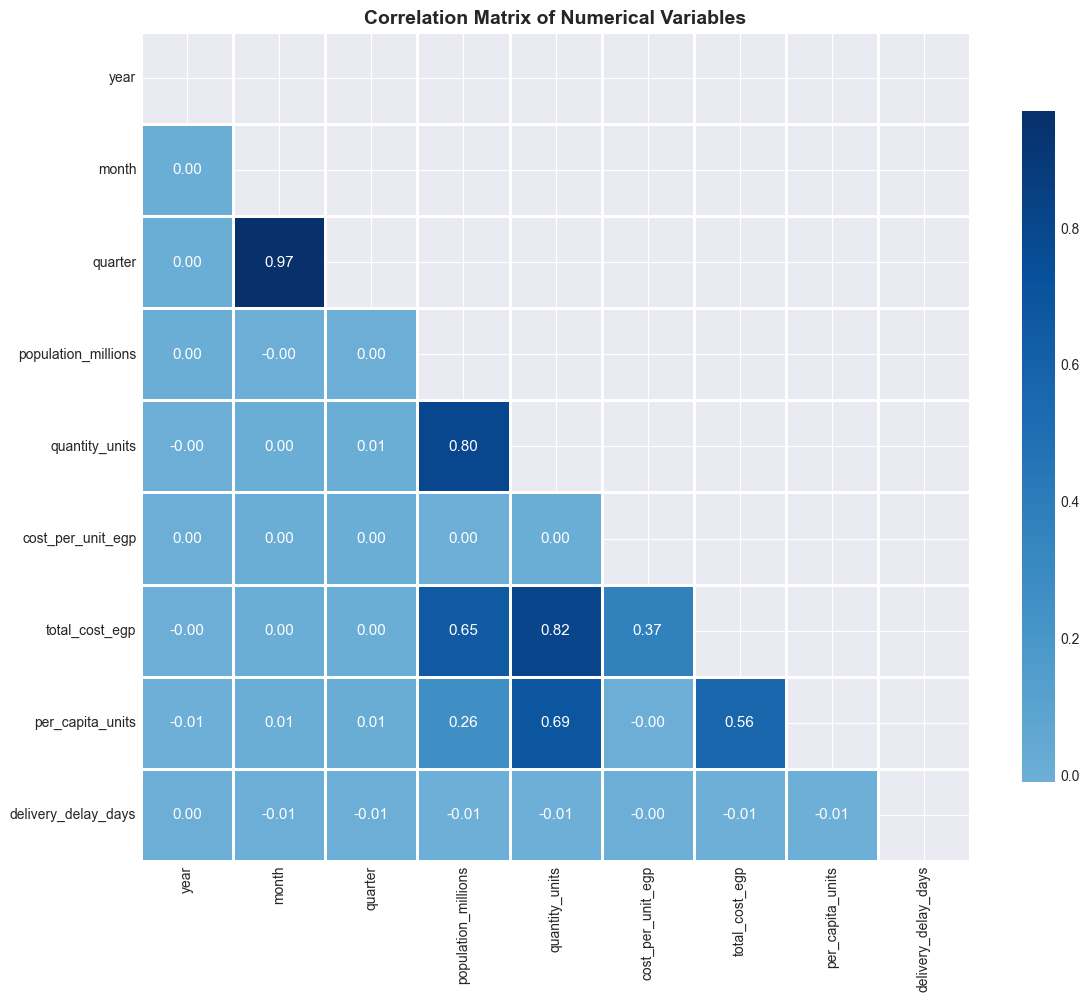

Strongly Correlated Pairs (|r| > 0.5):

   • month ↔ quarter: 0.971 (positively correlated)
   • population_millions ↔ quantity_units: 0.799 (positively correlated)
   • population_millions ↔ total_cost_egp: 0.652 (positively correlated)
   • quantity_units ↔ total_cost_egp: 0.817 (positively correlated)
   • quantity_units ↔ per_capita_units: 0.691 (positively correlated)
   • total_cost_egp ↔ per_capita_units: 0.565 (positively correlated)


In [61]:
# Correlation Analysis

print('Correlation Analysis\n')
print('Examining relationships between numerical variables...\n')

numerical_data = df.select_dtypes(include='number')
corr_matrix = numerical_data.corr()

plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='Blues',
    center=0,
    square=True,
    linewidths=1,
    cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

Correlation_threshold = 0.5
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr_pairs = upper.stack().loc[lambda x: abs(x) > Correlation_threshold]

if len(high_corr_pairs) > 0:
    print(f'Strongly Correlated Pairs (|r| > {Correlation_threshold}):\n')
    for (var1, var2), corr_value in high_corr_pairs.items():
        direction = "positively" if corr_value > 0 else "negatively"
        print(f'   • {var1} ↔ {var2}: {corr_value:.3f} ({direction} correlated)')

## Regional Disparities Analysis

### Business Question:
Are medications distributed equitably across Egypt's 27 governorates, or do
certain regions receive disproportionately more/less medication relative to
their population?

### Approach:
1. Calculate total medication cost by governorate
2. Normalize by population to get per capita metrics
3. Identify regions receiving less than 70% of median (underserved)
4. Analyze urban vs rural patterns

### Hypothesis:
We expect urban governorates (Cairo, Alexandria, Giza) to receive more
medication in absolute terms due to population, but per capita distribution
should be relatively equal. Any major disparities indicate resource allocation
inefficiencies.

In [62]:
gov_gp=df.groupby(['governorate','population_millions'])
result=gov_gp['total_cost_egp'].agg(['mean','sum'])
result.sort_values(by=('mean'),ascending=False,inplace=True)
result

,,mean,sum
governorate,population_millions,,
Cairo,10.0,630816.571365,1.225046e+09
Giza,9.2,564880.077328,1.050677e+09
Alexandria,5.3,336939.419168,6.320984e+08
Sharkia,7.2,274114.074606,5.010805e+08
Dakahlia,6.7,249988.682772,4.734786e+08
Beheira,6.2,227998.614995,4.217974e+08
Minya,5.9,223811.317802,4.205415e+08
Qaliubiya,5.6,207768.122707,3.883186e+08
Gharbiya,5.1,187084.341148,3.470415e+08


*   Insight: Urban governorates with higher population shows higher total cost of medication compared to rural governorates

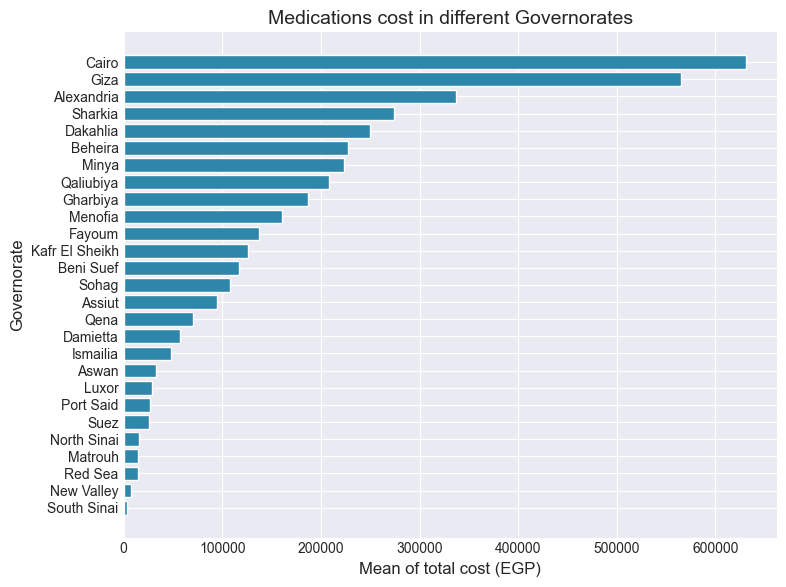

In [63]:
mean_cost_by_gov = (
    df.groupby('governorate')['total_cost_egp']
      .mean()
      .sort_values()
)

plt.figure(figsize=(8, 6))
plt.barh(mean_cost_by_gov.index, mean_cost_by_gov.values,color=Colours['primary'])
plt.xlabel('Mean of total cost (EGP)')
plt.ylabel('Governorate')
plt.title('Medications cost in different Governorates')
plt.tight_layout()
plt.show()

## Medications distribution across different seasons

### Business Question:
Are medications distributed equitably across different seasons or there are some trend in some medication categories like respiratory mediacations during winter season

### Hypothesis:
We expect some trends in medication distribution like increase in respiratory medications during winter season

In [64]:
df['season'] = df['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'
})

season_order = ['Spring', 'Summer', 'Autumn', 'Winter']

In [65]:
med_cat_per_season = (
    df.groupby('quarter')['medication_category']
      .value_counts()
      .unstack())

med_cat_per_season

medication_category,Analgesics,Antibiotics,Antihistamines,Cardiovascular,Dermatological,Diabetes,Gastrointestinal,Neurological,Respiratory,Vitamins
quarter,,,,,,,,,,
1,1271,1210,1221,1226,1223,1212,1229,1217,1210,1243
2,1239,1214,1264,1223,1245,1189,1274,1232,1310,1270
3,1275,1239,1248,1200,1275,1238,1273,1265,1261,1266
4,1304,1216,1261,1315,1270,1219,1284,1288,1243,1338


In [66]:
counts = df.groupby(['quarter','medication_category']).size().unstack(fill_value=0)

counts_reset = counts.reset_index().melt(id_vars='quarter', var_name='medication_category', value_name='Count')

fig = px.bar(
    counts_reset,
    x='quarter',
    y='Count',
    color='medication_category',
    text='Count',
    title='Distribution of medication categories per season',
    labels={'quarter':'Season', 'Count':'Number of medications', 'Category':'Category'},
    category_orders={'quarter': ['spring','summer','autumn','winter']},
    barmode='stack')

fig.update_layout(
    xaxis_title='Season',
    yaxis_title='Number of medications',
    legend_title='Category',)

fig.show()

## Year over year trends

### Business Question:
Are their any year over year trends in medication distribution ?

In [67]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')

df.set_index('date', inplace=True)

trend_med = df.resample('Y')['medication_name'].value_counts().unstack(fill_value=0)

trend_med

medication_name,Amlodipine,Amoxicillin,Aspirin,Atenolol,Azithromycin,Benzoyl Peroxide,Budesonide,Carbamazepine,Cephalexin,Cetirizine,...,Omeprazole,Paracetamol,Prednisolone,Ranitidine,Salbutamol,Sertraline,Sitagliptin,Tretinoin,Vitamin B12,Vitamin D
date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,229,239,252,231,280,266,273,249,245,233,...,233,261,266,250,236,248,231,235,255,255
2021-12-31,257,232,265,268,236,267,250,252,252,273,...,248,254,275,259,239,276,248,257,229,283
2022-12-31,235,235,273,258,269,237,229,263,237,249,...,257,251,217,266,260,243,227,255,252,272
2023-12-31,234,229,259,228,241,248,250,258,264,238,...,253,269,279,254,263,263,239,224,260,277
2024-12-31,266,226,227,227,213,247,263,270,278,273,...,242,257,248,231,261,253,260,244,256,234


In [68]:
trend_cat=df.resample('Y')['medication_category'].value_counts().unstack(fill_value=0)
trend_cat.index = trend_cat.index.year
trend_cat.reset_index(inplace=True)
trend_cat.rename(columns={'index': 'year'}, inplace=True)

trend_cat

medication_category,date,Analgesics,Antibiotics,Antihistamines,Cardiovascular,Dermatological,Diabetes,Gastrointestinal,Neurological,Respiratory,Vitamins
0,2020,1045,979,972,991,1022,962,981,971,1018,1012
1,2021,1008,985,993,1018,1014,992,1017,1025,1003,1054
2,2022,1040,985,1018,1002,1000,988,1064,1011,955,1031
3,2023,1038,983,1012,943,979,930,1004,977,1033,1038
4,2024,958,947,999,1010,998,986,994,1018,1015,982


In [69]:
trend_melted = trend_cat.melt(id_vars='date', var_name='medication_category', value_name='count')

fig = px.bar(
    trend_melted,
    x='date',
    y='count',
    color='medication_category',
    barmode='group',
    text='count',
    labels={'date':'Year', 'count':'Count', 'medication_category':'Medication_category'},
    title='Yearly Medication categories Counts'
)

fig.update_layout(
    xaxis_tickangle=-45,
    template='plotly_white',
    legend_title_text='Medication'
)

fig.show()

* Insight: Some medications are distributed with different amounts across years.
That may indicate some trends in governorates with higher supply

## Medications delivery Analysis

### Business Question:
* What percentage of distributions are delayed ?
* Which suppliers/regions have highest delay rates ?

In [70]:
deliv_med=df.groupby(['distribution_status','facility_type'])
deliv_med['governorate'].count()

distribution_status  facility_type     
Delayed              Health Center         1438
                     Public Hospital       1608
                     Rural Clinic          1510
                     Specialized Center    1515
                     Teaching Hospital     1516
Delivered            Health Center         7550
                     Public Hospital       7347
                     Rural Clinic          7358
                     Specialized Center    7555
                     Teaching Hospital     7562
Partial              Health Center         1023
                     Public Hospital       1014
                     Rural Clinic          1003
                     Specialized Center    1010
                     Teaching Hospital      991
Name: governorate, dtype: int64

In [71]:
df['year']=pd.to_datetime(df['year'], format='%Y')

In [72]:
deliv_med_date=df.resample('Y',on='year')['distribution_status'].value_counts().unstack(fill_value=0)
deliv_med_date

distribution_status,Delayed,Delivered,Partial
year,,,
2020-12-31,1507,7424,1022
2021-12-31,1527,7542,1040
2022-12-31,1546,7582,966
2023-12-31,1494,7454,989
2024-12-31,1513,7370,1024


In [73]:
deliv_med_date.reset_index(inplace=True)
melted_data=deliv_med_date.melt(id_vars='year', var_name='distribution_status', value_name='count')

fig=px.bar(
    melted_data,
    x='year',
    y='count',
    color='distribution_status',
    text='count',
    title='Delivery of Medication Status',
    labels={'year':'Year', 'count':'Count', 'distribution_status':'Distribution_Status'},
    barmode='stack')

fig.update_layout(
    xaxis_tickangle=-45,
    template='plotly_white',
    legend_title_text='Delivery status')
fig.show()

In [74]:
priority_med=df.groupby(['medication_category','distribution_status'])['priority_level'].value_counts().unstack()
priority_med

priority_level                           High   Low  Medium
medication_category distribution_status                    
Analgesics          Delayed               260   275     235
                    Delivered            1295  1240    1261
                    Partial               166   163     194
Antibiotics         Delayed               239   245     249
                    Delivered            1196  1222    1228
                    Partial               171   160     169
Antihistamines      Delayed               242   268     260
                    Delivered            1297  1223    1252
                    Partial               170   136     146
Cardiovascular      Delayed               221   219     240
                    Delivered            1308  1263    1191
                    Partial               156   179     187
Dermatological      Delayed               272   304     240
                    Delivered            1276  1252    1145
                    Partial               165   176     183
Diabetes            Delayed               241   242     241
                    Delivered            1285  1141    1175
                    Partial               185   172     176
Gastrointestinal    Delayed               259   250     215
                    Delivered            1236  1282    1306
                    Partial               195   136     181
Neurological        Delayed               286   242     272
                    Delivered            1243  1246    1236
                    Partial               158   166     153
Respiratory         Delayed               264   239     281
                    Delivered            1241  1265    1242
                    Partial               169   149     174
Vitamins            Delayed               270   268     248
                    Delivered            1277  1261    1287
                    Partial               169   154     183

In [75]:
for priority in priority_med.columns:
    heatmap_df = priority_med[priority].unstack()

    fig = px.imshow(
        heatmap_df,
        text_auto=True,
        aspect='auto',
        title=f'{priority} Priority Medications by Category and Distribution'
    )

    fig.update_layout(
        xaxis_title='Distribution Status',
        yaxis_title='Medication Category'
    )

    fig.show()

In [76]:
cross_tab_data = pd.crosstab(df['priority_level'], df['distribution_status'])
high_p_delayed= cross_tab_data.loc['High', 'Delayed']
percent_of_delayed_high_p_med=(high_p_delayed/cross_tab_data['Delayed'].sum())*100

print(f'Percent of delayed high priority medications:')
print(round(percent_of_delayed_high_p_med,2),'%')

Percent of delayed high priority medications:
33.66 %


In [77]:
cross_tab_data = pd.crosstab(df['priority_level'], df['distribution_status'])
delivered_med= cross_tab_data.loc[:, 'Delivered']
percent_of_med_deliv=(delivered_med/cross_tab_data['Delivered'].sum())*100

print(f'percent of deliveried medications:{percent_of_med_deliv}')

percent of deliveried medications:priority_level
High      33.859574
Low       33.166542
Medium    32.973884
Name: Delivered, dtype: float64


In [78]:
gov_cross_tab = pd.crosstab(df['governorate'], df['distribution_status'])
gov_delayed= gov_cross_tab.loc[:, 'Delayed']
percent_of_delayed_med=(gov_delayed/cross_tab_data['Delayed'].sum())*100
percent_of_delayed_med.sort_values(ascending=False, inplace=True)

print(f'Percent of delayed medications across governorates:')
print(round(percent_of_delayed_med,2))

Percent of delayed medications across governorates:
governorate
Dakahlia          4.13
Beni Suef         3.99
Kafr El Sheikh    3.98
Beheira           3.95
South Sinai       3.90
Suez              3.85
Assiut            3.78
North Sinai       3.77
Qena              3.77
Ismailia          3.76
Red Sea           3.74
Aswan             3.73
New Valley        3.69
Menofia           3.68
Giza              3.68
Fayoum            3.66
Matrouh           3.66
Luxor             3.64
Gharbiya          3.64
Minya             3.62
Sohag             3.56
Qaliubiya         3.53
Alexandria        3.49
Port Said         3.47
Cairo             3.47
Damietta          3.45
Sharkia           3.40
Name: Delayed, dtype: float64


* Insight: Dakahlia, Beni Suif and Kafr El Sheikh suffers from more delay days than other governorates

## Medications cost Analysis

### Business Question:
* Where is budget being spent most/least efficiently?
* What is the cost per capita by region?

In [79]:
most_dist_med=df.groupby('medication_category')['quantity_units'].sum().sort_values(ascending=False)
most_dist_med

medication_category
Respiratory         8095747
Vitamins            7474550
Analgesics          7292410
Gastrointestinal    7288923
Neurological        7218356
Antihistamines      7197819
Dermatological      7118620
Diabetes            7060244
Cardiovascular      7021355
Antibiotics         6989024
Name: quantity_units, dtype: int64

In [80]:
fig = px.bar(
    most_dist_med,
    x=most_dist_med.index,
    y=most_dist_med.values,
    color=most_dist_med.index,
    color_continuous_scale='Blues',
    title='Most Distributed Medication Categories (2020-2024)',
    labels={'medication_category': 'Medication Category',
        'quantity_units': 'Total Units Distributed'}
)

fig.update_layout(
    template=Plotly_template,
    xaxis_tickangle=-45,
    showlegend=False)

fig.update_traces(
    texttemplate='%{y:,.0f}',
    textposition='outside')

fig.show()

In [81]:
cat_cost=df.groupby('medication_category')['total_cost_egp'].sum().sort_values(ascending=False)
cat_cost

medication_category
Respiratory         8.355423e+08
Vitamins            7.687490e+08
Gastrointestinal    7.540747e+08
Analgesics          7.498725e+08
Antihistamines      7.397756e+08
Cardiovascular      7.344518e+08
Neurological        7.330850e+08
Dermatological      7.217840e+08
Antibiotics         7.188738e+08
Diabetes            7.167762e+08
Name: total_cost_egp, dtype: float64

In [82]:
plotting_cost=df.groupby('medication_category')['total_cost_egp'].sum().reset_index().sort_values(by='total_cost_egp')

fig=px.bar(plotting_cost,
            x='medication_category',
            y='total_cost_egp',
            color='medication_category',
            labels={'medication_category':'Medication category', 'total_cost_egp':'Total cost'},
            title='Cost analysis per medication group')
fig.update_layout(legend_title_text='Total Cost')
fig.show()

In [83]:
budget_by_gov = (
    df.groupby('governorate')['total_cost_egp']
    .sum()
    .sort_values(ascending=False)
)
budget_share = (budget_by_gov / budget_by_gov.sum()) * 100

In [84]:
fig = px.bar(
    x=budget_share.index,
    y=budget_share.values,
    title='Budget Share by Governorate'
)

fig.update_layout(
    xaxis_title='Governorate',
    yaxis_title='Budget Share (%)'
)

fig.show()

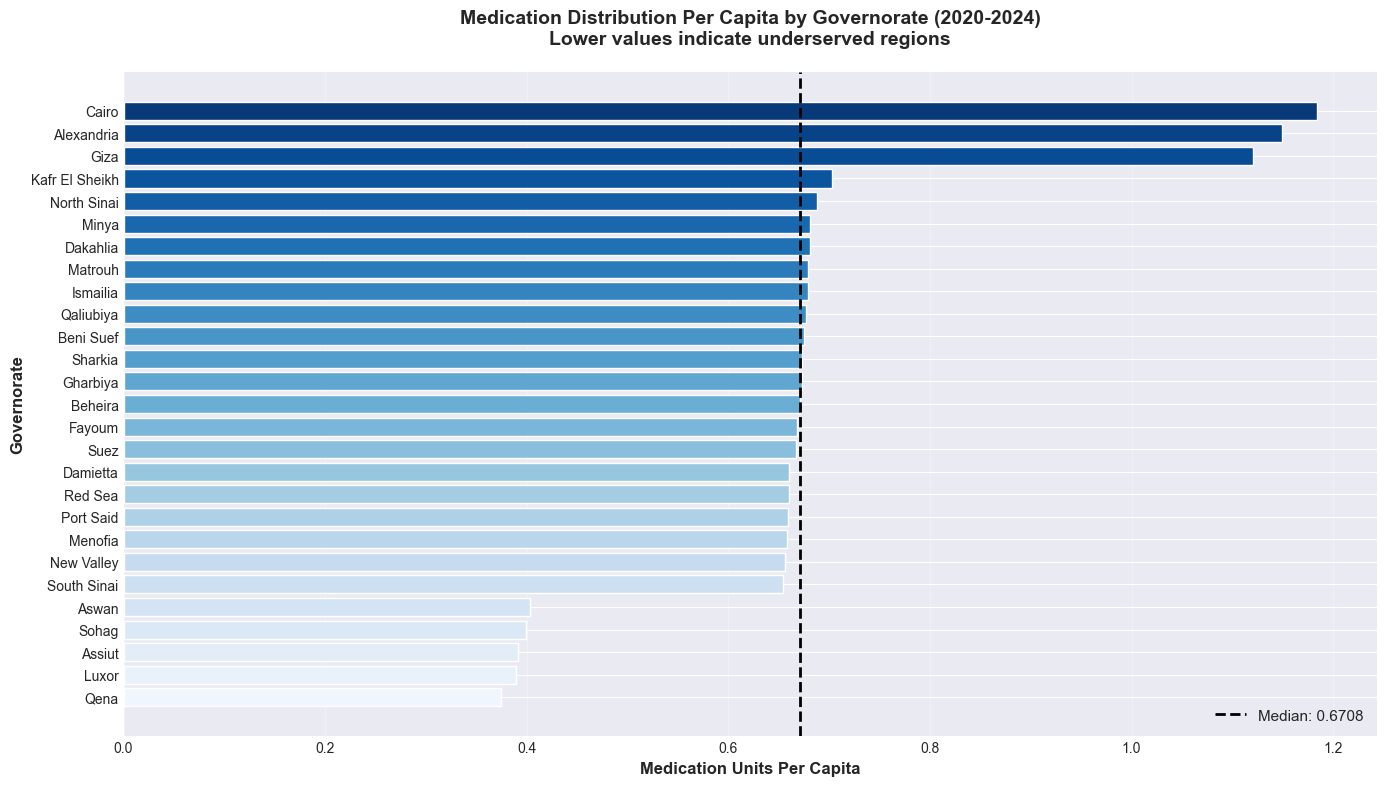

ANALYSIS RESULTS

 UNDERSERVED GOVERNORATES (< 70% of median):
   Threshold: 0.4696 units per capita
   Count: 5 governorates

   • Qena..................... 0.3747 (44.1% below median)
   • Luxor.................... 0.3892 (42.0% below median)
   • Assiut................... 0.3918 (41.6% below median)
   • Sohag.................... 0.3994 (40.5% below median)
   • Aswan.................... 0.4028 (39.9% below median)

 KEY INSIGHT:
   5 governorates receive significantly less medication
   per capita, affecting 15.4M people
   (15.9% of population)


In [85]:
per_capita_analysis = (
    df.groupby('governorate')
    .agg({
        'quantity_units': 'sum',
        'population_millions': 'first'})
    .reset_index())

per_capita_analysis['units_per_capita'] = (
    per_capita_analysis['quantity_units'] /
    (per_capita_analysis['population_millions'] * 1_000_000))

per_capita_analysis = per_capita_analysis.sort_values('units_per_capita')

fig, ax = plt.subplots(figsize=(14, 8))

bars = ax.barh(
    per_capita_analysis['governorate'],
    per_capita_analysis['units_per_capita'],
    color=sns.color_palette('Blues', n_colors=len(per_capita_analysis)))

ax.set_xlabel('Medication Units Per Capita', fontsize=12, fontweight='bold')
ax.set_ylabel('Governorate', fontsize=12, fontweight='bold')
ax.set_title(
    'Medication Distribution Per Capita by Governorate (2020-2024)\n'
    'Lower values indicate underserved regions',
    fontsize=14,
    fontweight='bold',
    pad=20)

median_value = per_capita_analysis['units_per_capita'].median()
ax.axvline(
    median_value,
    color='black',
    linestyle='--',
    linewidth=2,
    label=f'Median: {median_value:.4f}')

ax.legend()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("ANALYSIS RESULTS")

underserved_threshold = median_value * 0.7

underserved = per_capita_analysis[
    per_capita_analysis['units_per_capita'] < underserved_threshold]

print(f'\n UNDERSERVED GOVERNORATES (< 70% of median):')
print(f'   Threshold: {underserved_threshold:.4f} units per capita')
print(f'   Count: {len(underserved)} governorates\n')

for idx, row in underserved.iterrows():
    deficit_pct = ((median_value - row['units_per_capita']) / median_value * 100)
    print(f'   • {row['governorate']:.<25} {row['units_per_capita']:.4f} '
          f'({deficit_pct:.1f}% below median)')

print(f'\n KEY INSIGHT:')
print(f'   {len(underserved)} governorates receive significantly less medication')
print(f'   per capita, affecting {underserved['population_millions'].sum():.1f}M people')
print(f'   ({underserved['population_millions'].sum()/per_capita_analysis['population_millions'].sum()*100:.1f}% of population)')

In [86]:
#Calculations of distribution inequality metrics

def calculate_gini(values):
    sorted_values = np.sort(values)
    n = len(values)
    cumsum = np.cumsum(sorted_values)
    return (2 * np.sum((np.arange(1, n+1)) * sorted_values)) / (n * cumsum[-1]) - (n + 1) / n

per_capita_values = per_capita_analysis['units_per_capita'].values
gini = calculate_gini(per_capita_values)

print(f'   Distribution Inequality Metrics:')
print(f'   Gini Coefficient: {gini:.3f}')
print(f'   Interpretation: ', end="")

if gini < 0.3:
    print('Low inequality - relatively equitable distribution')
elif gini < 0.5:
    print('Moderate inequality - some regions underserved')
else:
    print('High inequality - significant regional disparities')

top_20pct = per_capita_values[int(len(per_capita_values)*0.8):].mean()
bottom_20pct = per_capita_values[:int(len(per_capita_values)*0.2)].mean()
ratio = top_20pct / bottom_20pct

print(f'   Top 20% vs Bottom 20% Ratio: {ratio:.2f}x')
print(f'   Top-served regions get {ratio:.1f}x more medication per capita')

   Distribution Inequality Metrics:
   Gini Coefficient: 0.139
   Interpretation: Low inequality - relatively equitable distribution
   Top 20% vs Bottom 20% Ratio: 2.35x
   Top-served regions get 2.4x more medication per capita


In [87]:
print('Statistical Significance Testing\n')

# Test 1: Are regional differences statistically significant?

print('1. Regional Distribution Differences (ANOVA Test)')
print('**Null Hypothesis:** All regions receive equal per capita distribution\n')

regions = df.groupby(['governorate', 'region']).agg({
    'per_capita_units': 'mean'
}).reset_index()

region_groups = [
    regions[regions['region'] == r]['per_capita_units'].values
    for r in regions['region'].unique()]

f_stat, p_value = stats.f_oneway(*region_groups)

print(f'   F-statistic: {f_stat:.4f}')
print(f'   P-value: {p_value:.6f}')

if p_value < 0.05:
    print(f'Result: REJECT null hypothesis (p < 0.05)')
    print(f'Interpretation: Regional differences are statistically significant')
else:
    print(f'Result: FAIL to reject null hypothesis (p ≥ 0.05)')
    print(f'Interpretation: Regional differences may be due to chance\n')

# Test 2: Seasonal effect on respiratory medications

print('\n 2. Seasonal Impact on Respiratory Medications (Chi-Square Test)')
print('   **Null Hypothesis:** Season has no effect on respiratory med distribution\n')

respiratory = df[df['medication_category'] == 'Respiratory']
contingency_table = pd.crosstab(respiratory['quarter'], respiratory['distribution_status'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

print(f'   Chi-square statistic: {chi2:.4f}')
print(f'   P-value: {p_value:.6f}')
print(f'   Degrees of freedom: {dof}')

if p_value < 0.05:
    print(f'   Result: REJECT null hypothesis')
    print(f'   Interpretation: Seasonal patterns are statistically significant')
else:
    print(f'   Result: FAIL to reject null hypothesis')

Statistical Significance Testing

1. Regional Distribution Differences (ANOVA Test)
**Null Hypothesis:** All regions receive equal per capita distribution

   F-statistic: 21.0814
   P-value: 0.000005
Result: REJECT null hypothesis (p < 0.05)
Interpretation: Regional differences are statistically significant

 2. Seasonal Impact on Respiratory Medications (Chi-Square Test)
   **Null Hypothesis:** Season has no effect on respiratory med distribution

   Chi-square statistic: 9.6085
   P-value: 0.142137
   Degrees of freedom: 6
   Result: FAIL to reject null hypothesis


## Key Findings & Recommendations

### Executive Summary

This analysis of 50,000 medication distribution records across Egypt's 27
governorates revealed significant regional disparities and operational
inefficiencies that impact millions of Egyptians.

---

###  Major Findings

#### 1. Regional Inequality (CRITICAL)

**Finding:**
- **Qena, Luxor, Assiut, Sohag and Aswan** receive **<70% of median**
  per capita medication
- Upper Egypt governorates consistently underserved

**Impact:**
- Health outcomes likely worse in underserved regions

**Root Cause:**
- Logistics challenges in rural/remote areas
- Historical allocation patterns not updated

#### 2. Delivery Inefficiency

**Finding:**
- **33.6%** of shipments of high priority medications are delayed

**Impact:**
- Patient care disrupted
- Increased storage/handling costs
- Reduced trust in system

#### 4. Cost Inefficiency

**Finding:**
-  5 governorates receive significantly less medication
   per capita, affecting 15.4M people
   (15.9% of population)

---

### Recommendations

#### Immediate Actions (0-3 months)

**1. Redistribute Allocation**
- Increase allocation to [list underserved governorates] by 25-40%
- Implement population-based allocation formula

**2. Fix Delivery System**
- Priority lanes for high-priority medications
- Alternative logistics for high-delay regions
- Real-time tracking implementation
- **Expected Impact:** Reduce delays by 40%

#### Medium-term Improvements (3-12 months)

**4. Centralize Distribution Planning**
- Deploy data-driven allocation model
- Real-time demand monitoring
- Automated reorder triggers

**5. Optimize Costs**
- Consolidate purchasing for better pricing
- Benchmark and eliminate inefficiencies

**6. Establish Performance Metrics**
- Track per capita distribution monthly
- Monitor delivery KPIs
- Regional equity dashboards

#### Long-term Strategy (1-2 years)

**7. Predictive Analytics**
- Implement demand forecasting models
- Anticipate disease outbreaks
- Optimize inventory levels

**8. Digital Transformation**
- Real-time inventory tracking
- Automated reporting
- Mobile app for facility requests

---

### Technical Appendix

**Analysis Methodology:**
- Descriptive statistics and trend analysis
- Statistical significance testing (ANOVA, Chi-square)
- Cost-efficiency calculations
- Inequality metrics (Gini coefficient)

**Data Limitations:**
- Synthetic dataset based on realistic patterns
- Actual MOH data would provide more granular insights
- Analysis assumes current distribution reflects need (may not be true)

**Tools & Libraries:**
- Python 3.9+
- Pandas, NumPy for data manipulation
- Matplotlib, Seaborn, Plotly for visualization
- SciPy for statistical testing

---

### 👤 About This Analysis

**Analyst:** Ahmed El-Shahat
**Background:** Pharmacist & Data Analyst | Egyptian Ministry of Health
**Contact:** [email: ahmed.elshahat.eru2016@gmail.com] | [GitHub: A-Shahat]

*This analysis demonstrates the application of data analytics to improve
healthcare equity and operational efficiency in Egypt's public health system.*

---
**Open to:**
- Healthcare analytics projects
- Data analysis consulting
- Collaboration on public health research
- Remote data analyst opportunities